# Introduction to Deep Learning 67822 - [Ex3](https://docs.google.com/document/d/12ZI1Q5cpf2aClCAIB5Tr4hcF0gLowrVbG7cNWXoHFpY/edit?pli=1&tab=t.0)

## **Programing Task:** Sentiment Analysis for the IMDB Movies Reviews Dataset

The dataset consists of 50,000 annotated reviews. Each review is a plain text describing the viewers’ experience and opinion on the movie watched. The dataset consists of highly polar reviews and contains binary labels (positive and negative) based on the number of stars the movie received by the viewers. Some reviews are very long, but we will consider only the first 100 words they contain.

In this exercise we design networks that predict the viewers’ sentiment (positive/negative) towards the movies they watched based on the review they wrote. We will compare the following four different strategies:

1. The use of a simple Elman RNN  
2. The use of a simple GRU  
3. The use of a global average pooling. In this case every word goes through an MLP that result in a scalar, we call “*sub-prediction score”*, and these scores are then summed together to provide the final prediction  
4. Adding a local self-attention layer to Strategy \#3 in order to achieve crossword reasoning (contextualization)

The exercise comes with a partial code that loads the reviews from the dataset, and processes them into a long list of lower-case text (100 words, no punctuation/sentences, no special characters). Longer reviews are truncated, shorter ones are padded. This pre-processing uses the GloVe word embedding which maps every word into a 100-dimensional vector. To avoid over-fitting over this small dataset we do not allow this embedding to train; treat it as a frozen part of the model. You can read more about this embedding [here](https://nlp.stanford.edu/projects/glove/). Some parts of these pre-processing steps were taken from [this](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/) tutorial.

The exercise consists of the following specific tasks. 

### 1.
Fill in the missing lines of code in the RNN and GRU cells functions. The RNN contains some lines which you may find helpful (or choose to omit and implement on your own). The gates and update operators should consist of a single FC layer (hidden state dim. should be between 64-128 for the lowest test error). The convention of the tensors for these recurrent networks is N\_batch x N\_word x N\_features, or **batch element x “time index” x feature vector coordinate**. So the recurrence (your iteration in the code) should apply and advance on the second axis. Once the review is parsed, its hidden-state should pass through an MLP which produces the final output sentiment prediction (a 2-class one hot vector). Do not use a single output sentiment scalar for reasons that we will see below.  
Run each of these recurrent network architectures, describe your experiments with two different hidden-state dimensions (small/large),and the train/test accuracies obtained (with plots). Explain what could lead to the different results you found in the experiment (bothRNN vs GRU and hidden state size). Come up with a test review of your own that demonstrates the different capabilities of the tworecurrent models. Add this review (and maybe variations of it that you’ve experimented with), and the results obtained and yourexplanation to the report.

**Add to your PDF the code lines where you combine input with hidden state and apply the activation function in your RNN. In addition, add the lines that compute the reset gate and update gate in the GRU**

#### Setup

In [1]:
import os

# Create directories for organized output
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True) 
os.makedirs("logs", exist_ok=True)

In [2]:
import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import loader as ld

# CODE_CHANGE: Importing visualization module
################################################
from viz import plot_losses_and_accuracy
################################################


batch_size = 32
output_size = 2
hidden_size = 64        # to experiment with


# CODE_CHANGE: I moved those flags to the GRU vs RNN section
################################################
"""
run_recurrent = True    # else run Token-wise MLP
use_RNN = True          # otherwise GRU
"""
################################################

atten_size = 0          # atten > 0 means using restricted self atten

reload_model = False
num_epochs = 10
learning_rate = 0.001
test_interval = 50

# Loading sataset, use toy = True for obtaining a smaller dataset
train_dataset, test_dataset, num_words, input_size = ld.get_data_set(batch_size)

#### RNN Class Implementation

In [3]:
# Implements RNN Unit
class ExRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRNN, self).__init__()

        self.hidden_size = hidden_size
        self.sigmoid = torch.sigmoid

        # RNN Cell weights
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        # CODE_CHANGE: what else?
        ##################################################
        self.out = nn.Linear(hidden_size, output_size)
        ##################################################


    def name(self):
        return "RNN"

    def forward(self, x, hidden_state):

        # CODE_CHANGE: Implementation of RNN cell
        ##################################################
        # Concatenate input and hidden state
        combined = torch.cat((x, hidden_state), dim=1)  # Shape: (batch_size, input_size + hidden_size)

        # Apply linear transformation + tanh activation
        hidden = torch.tanh(self.in2hidden(combined))  # Updated hidden state

        output = self.out(hidden)  # final sentiment prediction
        ##################################################
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)

#### GRU Class Implementation

In [4]:
# Implements GRU Unit
class ExGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExGRU, self).__init__()
        self.hidden_size = hidden_size
        # GRU Cell weights
        # self.something =
        # etc ...

        # CODE_CHANGE: Initialize GRU Cell weights
        ##################################################
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)  # update gate
        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)  # reset gate
        self.W_h = nn.Linear(input_size + hidden_size, hidden_size)  # candidate hidden
        self.out = nn.Linear(hidden_size, output_size)
        ##################################################

    def name(self):
        return "GRU"

    def forward(self, x, hidden_state):
        # CODE_CHANGE: Implementation of GRU cell
        ##################################################
        # missing implementation
        combined = torch.cat((x, hidden_state), dim=1)

        # GRU gates
        z = torch.sigmoid(self.W_z(combined))     # update gate
        r = torch.sigmoid(self.W_r(combined))     # reset gate

        # candidate hidden state uses reset-applied hidden
        combined_reset = torch.cat((x, r * hidden_state), dim=1)
        h_tilde = torch.tanh(self.W_h(combined_reset))

        # final hidden state
        hidden = (1 - z) * hidden_state + z * h_tilde

        output = self.out(hidden)  # final sentiment prediction
        ##################################################
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)

#### Training/testing wrapper function

In [5]:
# CODE_CHANGE: I wrapped all the given tratining code in a function
################################################
def train_model(model, model_name, train_dataset, test_dataset, num_words, criterion, optimizer):
################################################

    # CODE_CHANGE: I add an accuracy and loss logger
    ################################################
    result_logger = []
    train_acc = 0.5
    test_acc = 0.5
    ################################################

    # CODE_CHANGE: I added code for saving the model text output.
    ################################################
    with open(f"logs/models_log.txt", "a") as f:
        log_text = (
            f"Running model: {model_name}"
        )
        f.write(log_text + "\n")
    ################################################

    train_loss = 1.0
    test_loss = 1.0

    for epoch in range(num_epochs):

        itr = 0 # iteration counter within each epoch

        for labels, reviews, reviews_text in train_dataset:   # getting training batches

            itr = itr + 1

            if (itr + 1) % test_interval == 0:
                test_iter = True
                labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
            else:
                test_iter = False

            # Recurrent nets (RNN/GRU)

            if run_recurrent:
                hidden_state = model.init_hidden(int(labels.shape[0]))

                for i in range(num_words):
                    output, hidden_state = model(reviews[:,i,:], hidden_state)  # HIDE

            else:  

            # Token-wise networks (MLP / MLP + Atten.) 
            
                sub_score = []
                if atten_size > 0:  
                    # MLP + atten
                    sub_score, atten_weights = model(reviews)
                else:               
                    # MLP
                    sub_score = model(reviews)

                output = torch.mean(sub_score, 1)
                
            # cross-entropy loss

            loss = criterion(output, labels)

            # CODE_CHANGE: I added accuracy calculation
            ################################################
            _, predicted = torch.max(output, 1)
            _, actual = torch.max(labels, 1)
            correct = (predicted == actual).float().sum()
            accuracy = correct / labels.size(0)
            ################################################

            # optimize in training iterations

            if not test_iter:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # averaged losses
            if test_iter:
                test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss

                # CODE_CHANGE: I added code to update accuracy
                ################################################
                test_acc = 0.8 * float(accuracy) + 0.2 * test_acc
                ################################################

            else:
                train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss

                # CODE_CHANGE: I added code to update accuracy
                ################################################
                train_acc = 0.9 * float(accuracy) + 0.1 * train_acc
                ################################################
            if test_iter:

                # CODE_CHANGE:
                # I moved this printing code to the end of epoch loop,
                # in order to print accuracies. also, 
                # for printing only per epoch for more clairty.
                # the data per interval is still logged to a file,
                # and will be shown in the plots.
                ################################################
                """
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Step [{itr + 1}/{len(train_dataset)}], "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Test Loss: {test_loss:.4f}"
                )
                """
                ################################################


                # CODE_CHANGE: I Added code for saving the model text output.
                ################################################
                with open(f"logs/models_log.txt", "a") as f:
                    log_text = (
                        f"Epoch [{epoch + 1}/{num_epochs}] | "
                        f"Step [{itr + 1}/{len(train_dataset)}] | "
                        f"Train Loss: {train_loss:.4f} | "
                        f"Test Loss: {test_loss:.4f} | "
                        f"Train Acc: {train_acc:.4f} | "
                        f"Test Acc: {test_acc:.4f}"
                    )
                    f.write(log_text + "\n")
                ################################################
                

                # CODE_CHANGE: I Added code to log the losses and accuracies
                ################################################
                result_logger.append({
                    'epoch': epoch + 1,
                    'step': itr + 1,
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                    'train_acc': train_acc,
                    'test_acc': test_acc
                })
                ################################################


                if not run_recurrent:
                    nump_subs = sub_score.detach().numpy()
                    labels = labels.detach().numpy()
                    print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])
                # saving the model
                # CODE_CHANGE: I added code to save the model in a specific folder
                ################################################
                torch.save(model, f"models/{model_name}.pth")
                ################################################

        
        # CODE_CHANGE:
        # I moved this printing code is now in the end of the epoch loop
        # instead of per interval, for more clairty.
        # it also print accuracies now.
        ################################################         
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] | "
            f"Step [{itr}/{len(train_dataset)}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )
        ################################################


    # CODE_CHANGE: returning losses and accuracies logger
    ################################################
    return result_logger
    ################################################


#### RNN vs GRU with 2 hidden sizes, results

Running model: Q1_ExRNN_hidden64
Epoch [1/10] | Step [938/938] | Train Loss: 0.7035 | Test Loss: 0.6762 | Train Acc: 0.4970 | Test Acc: 0.5875
Epoch [2/10] | Step [938/938] | Train Loss: 0.7181 | Test Loss: 0.7008 | Train Acc: 0.4080 | Test Acc: 0.5130
Epoch [3/10] | Step [938/938] | Train Loss: 0.7032 | Test Loss: 0.7151 | Train Acc: 0.4352 | Test Acc: 0.4845
Epoch [4/10] | Step [938/938] | Train Loss: 0.6901 | Test Loss: 0.6809 | Train Acc: 0.6197 | Test Acc: 0.4501
Epoch [5/10] | Step [938/938] | Train Loss: 0.6650 | Test Loss: 0.6692 | Train Acc: 0.6733 | Test Acc: 0.6375
Epoch [6/10] | Step [938/938] | Train Loss: 0.6222 | Test Loss: 0.6411 | Train Acc: 0.5644 | Test Acc: 0.6630
Epoch [7/10] | Step [938/938] | Train Loss: 0.6615 | Test Loss: 0.6808 | Train Acc: 0.5322 | Test Acc: 0.5711
Epoch [8/10] | Step [938/938] | Train Loss: 0.6519 | Test Loss: 0.6783 | Train Acc: 0.5127 | Test Acc: 0.6377
Epoch [9/10] | Step [938/938] | Train Loss: 0.6549 | Test Loss: 0.6926 | Train Acc: 0.6

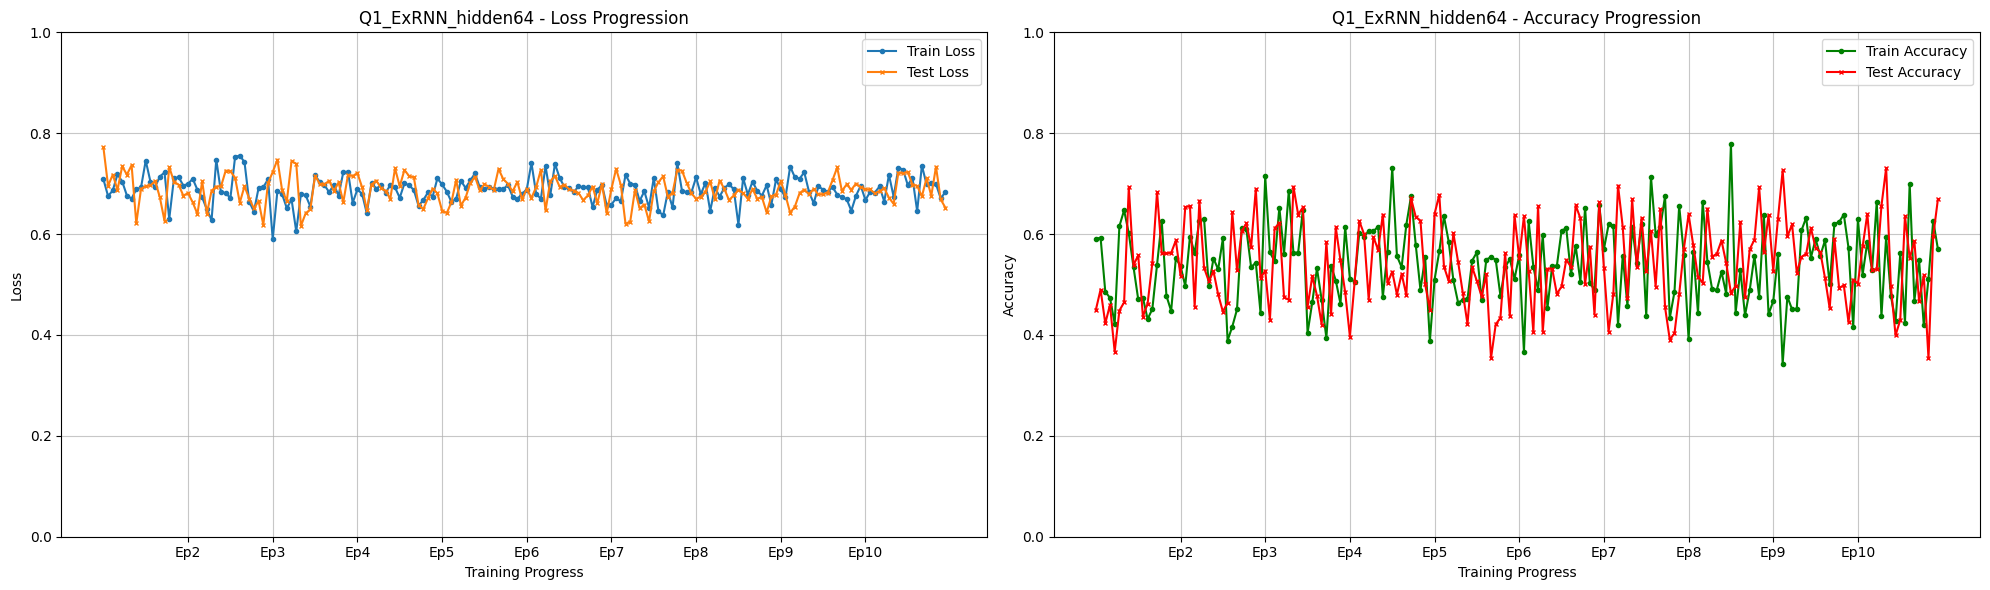

Running model: Q1_ExGRU_hidden64
Epoch [1/10] | Step [938/938] | Train Loss: 0.3807 | Test Loss: 0.4685 | Train Acc: 0.8160 | Test Acc: 0.8412
Epoch [2/10] | Step [938/938] | Train Loss: 0.5400 | Test Loss: 0.3880 | Train Acc: 0.8131 | Test Acc: 0.7885
Epoch [3/10] | Step [938/938] | Train Loss: 0.3433 | Test Loss: 0.5113 | Train Acc: 0.8188 | Test Acc: 0.8530
Epoch [4/10] | Step [938/938] | Train Loss: 0.2409 | Test Loss: 0.4441 | Train Acc: 0.8753 | Test Acc: 0.7978
Epoch [5/10] | Step [938/938] | Train Loss: 0.1525 | Test Loss: 0.3438 | Train Acc: 0.9787 | Test Acc: 0.8231
Epoch [6/10] | Step [938/938] | Train Loss: 0.2058 | Test Loss: 0.3832 | Train Acc: 0.9762 | Test Acc: 0.8171
Epoch [7/10] | Step [938/938] | Train Loss: 0.3875 | Test Loss: 0.4199 | Train Acc: 0.8250 | Test Acc: 0.8409
Epoch [8/10] | Step [938/938] | Train Loss: 0.3454 | Test Loss: 0.6909 | Train Acc: 0.8247 | Test Acc: 0.7130
Epoch [9/10] | Step [938/938] | Train Loss: 0.1764 | Test Loss: 0.4612 | Train Acc: 0.9

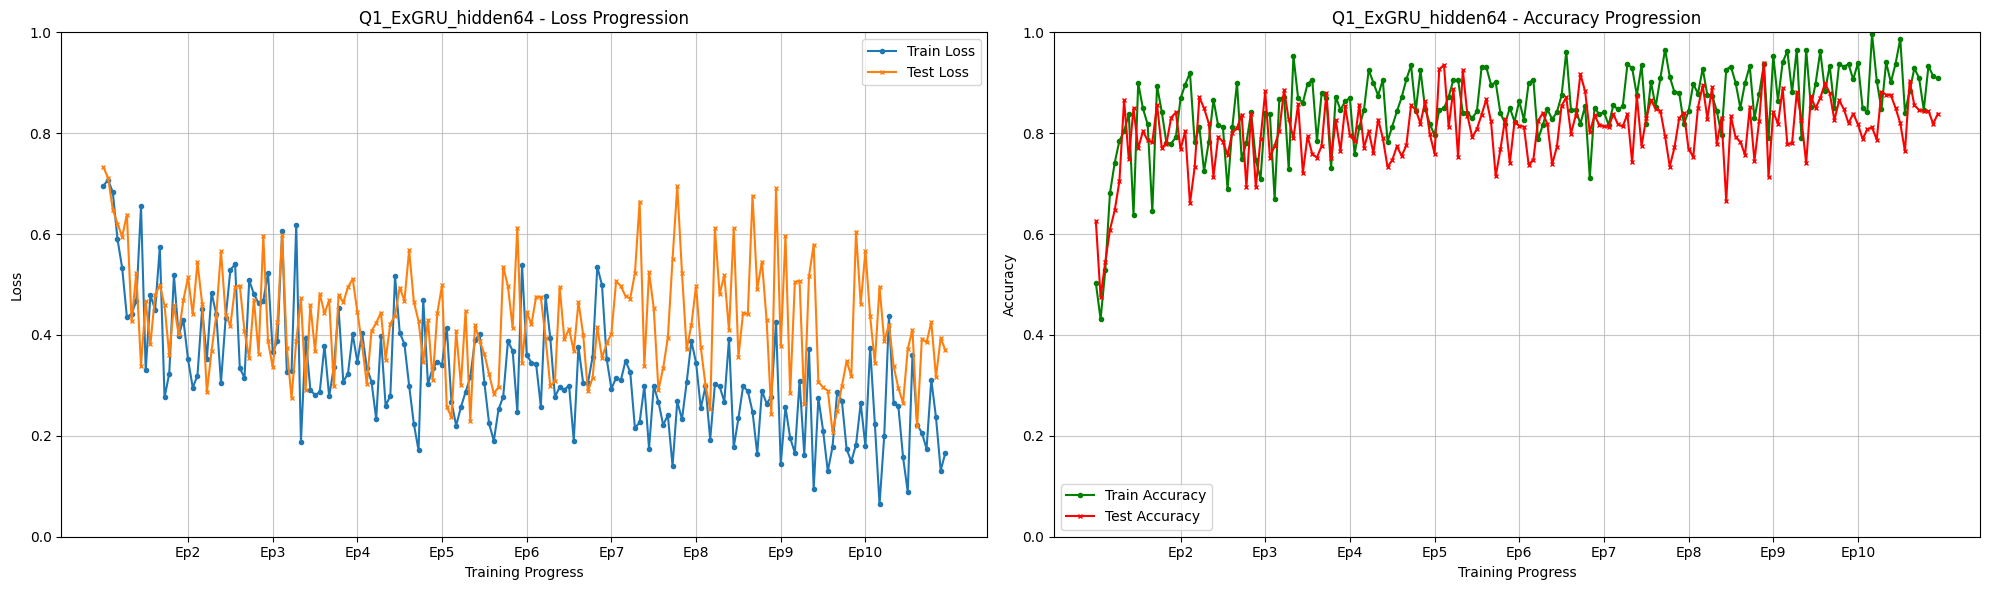

Running model: Q1_ExRNN_hidden128
Epoch [1/10] | Step [938/938] | Train Loss: 0.6130 | Test Loss: 0.6553 | Train Acc: 0.7794 | Test Acc: 0.5616
Epoch [2/10] | Step [938/938] | Train Loss: 0.6834 | Test Loss: 0.6761 | Train Acc: 0.5649 | Test Acc: 0.5929
Epoch [3/10] | Step [938/938] | Train Loss: 0.6979 | Test Loss: 0.7088 | Train Acc: 0.3386 | Test Acc: 0.4587
Epoch [4/10] | Step [938/938] | Train Loss: 0.6901 | Test Loss: 0.7056 | Train Acc: 0.5573 | Test Acc: 0.5745
Epoch [5/10] | Step [938/938] | Train Loss: 0.6234 | Test Loss: 0.7171 | Train Acc: 0.7316 | Test Acc: 0.4082
Epoch [6/10] | Step [938/938] | Train Loss: 0.6973 | Test Loss: 0.6829 | Train Acc: 0.5658 | Test Acc: 0.5389
Epoch [7/10] | Step [938/938] | Train Loss: 0.7346 | Test Loss: 0.6770 | Train Acc: 0.3358 | Test Acc: 0.5845
Epoch [8/10] | Step [938/938] | Train Loss: 0.7617 | Test Loss: 0.6277 | Train Acc: 0.4369 | Test Acc: 0.5749
Epoch [9/10] | Step [938/938] | Train Loss: 0.6989 | Test Loss: 0.6953 | Train Acc: 0.

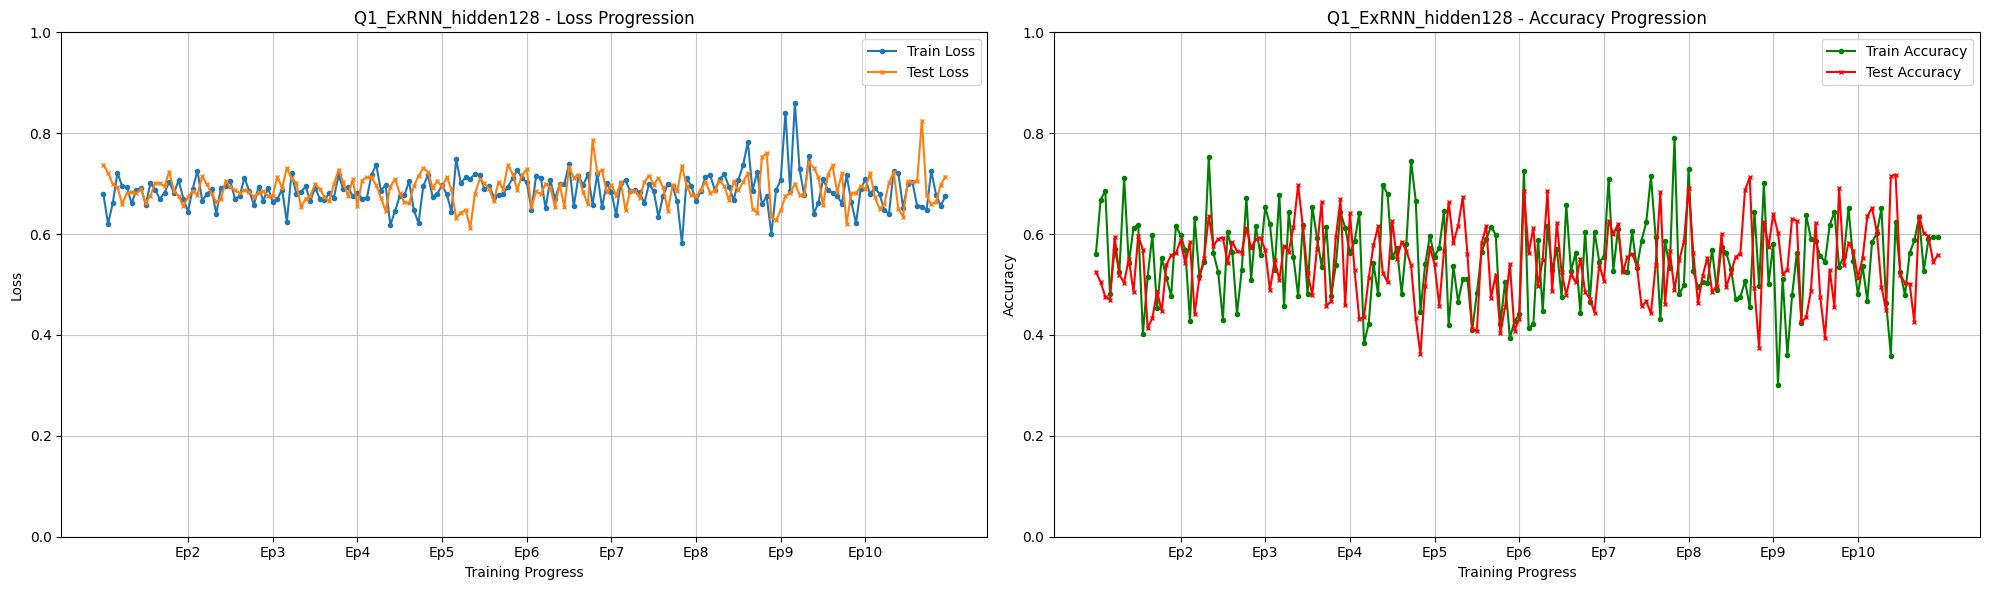

Running model: Q1_ExGRU_hidden128
Epoch [1/10] | Step [938/938] | Train Loss: 0.3888 | Test Loss: 0.3918 | Train Acc: 0.8153 | Test Acc: 0.8542
Epoch [2/10] | Step [938/938] | Train Loss: 0.2834 | Test Loss: 0.3989 | Train Acc: 0.8694 | Test Acc: 0.7422
Epoch [3/10] | Step [938/938] | Train Loss: 0.5441 | Test Loss: 0.3024 | Train Acc: 0.7062 | Test Acc: 0.8191
Epoch [4/10] | Step [938/938] | Train Loss: 0.3561 | Test Loss: 0.3251 | Train Acc: 0.8160 | Test Acc: 0.8197
Epoch [5/10] | Step [938/938] | Train Loss: 0.6841 | Test Loss: 0.2988 | Train Acc: 0.6959 | Test Acc: 0.8399
Epoch [6/10] | Step [938/938] | Train Loss: 0.3049 | Test Loss: 0.2443 | Train Acc: 0.8157 | Test Acc: 0.9401
Epoch [7/10] | Step [938/938] | Train Loss: 0.2354 | Test Loss: 0.3959 | Train Acc: 0.8809 | Test Acc: 0.8366
Epoch [8/10] | Step [938/938] | Train Loss: 0.3281 | Test Loss: 0.5049 | Train Acc: 0.7631 | Test Acc: 0.7886
Epoch [9/10] | Step [938/938] | Train Loss: 0.0883 | Test Loss: 0.3165 | Train Acc: 0.

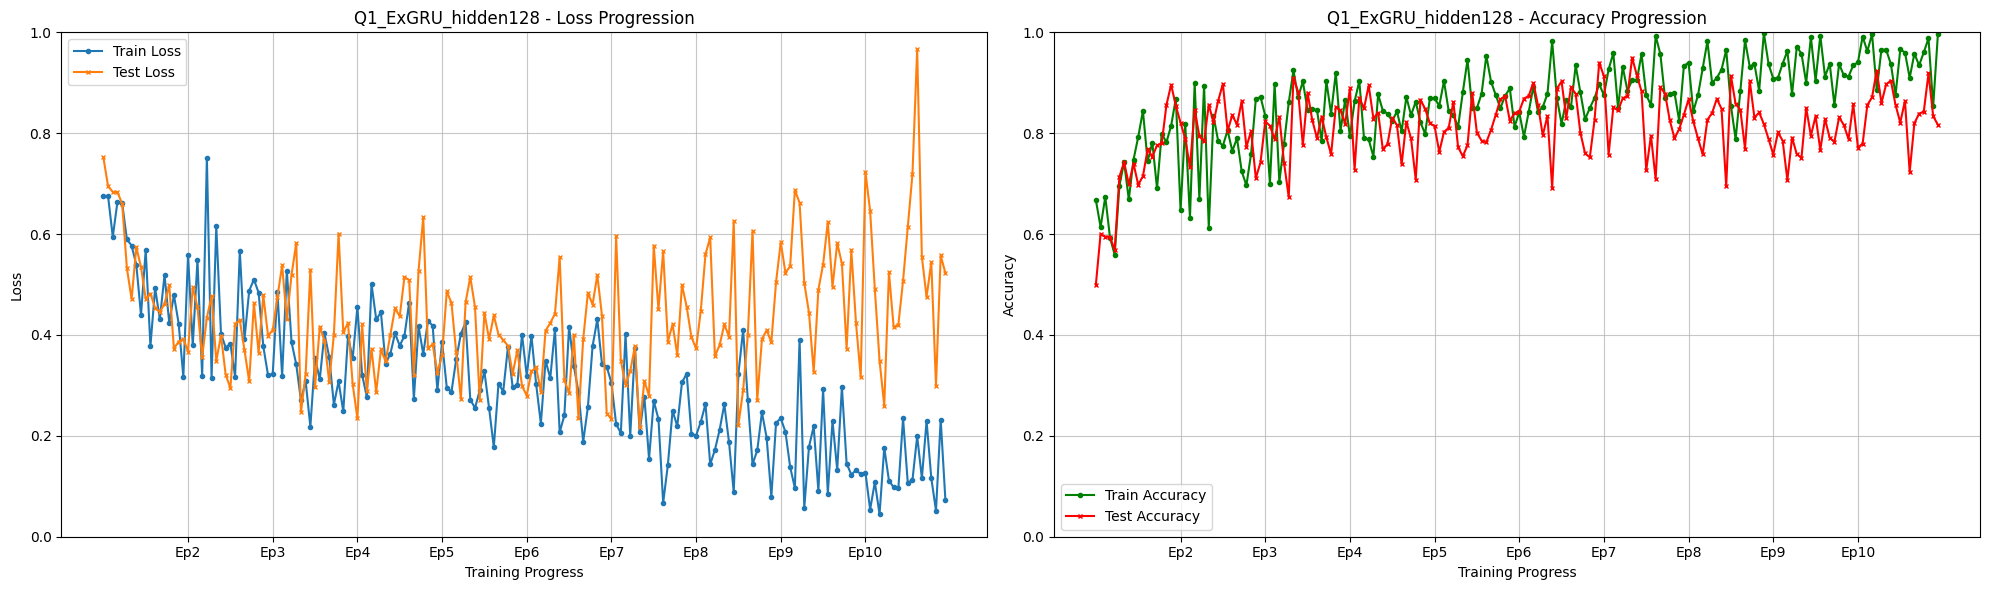

In [6]:
run_recurrent = True    # else run Token-wise MLP
use_RNN = True          # otherwise GRU

# Compare RNN vs GRU across hidden sizes
for hidden_size in [64, 128]:  # Sweep over small and large hidden states
    for model_class in [ExRNN, ExGRU]: # Sweep over RNN and GRU
        if model_class == ExRNN:
            run_recurrent = True
            use_RNN = True
        elif model_class == ExGRU:
            run_recurrent = True
            use_RNN = False
        model_name = f"Q1_{model_class.__name__}_hidden{hidden_size}"
        print(f"Running model: {model_name}")

        model = model_class(input_size, output_size, hidden_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)mac

        log_loss = train_model(
            model, model_name, train_dataset, test_dataset,
            num_words, criterion, optimizer
        )
        plot_losses_and_accuracy(log_loss, model_name)

#### Experimental Results Summary

From the training logs, we observe dramatic differences between RNN and GRU performance:

**Key Findings:**
1. **GRU vastly outperforms RNN**: GRU achieves ~90% test accuracy vs RNN's ~60%
2. **GRU converges much faster**: Reaches high accuracy by epoch 2-3
3. **Overfitting patterns differ**: GRU shows more overfitting with larger hidden size
4. **RNN struggles with learning**: Shows minimal improvement across epochs

#### Why GRU Outperforms RNN

1. **Gradient Flow**: GRU's gating mechanisms create shortcuts for gradients, preventing vanishing gradient problems that plague simple RNNs in long sequences (100 words)

2. **Selective Memory**: The reset gate (r) and update gate (z) allow GRU to:
   - Forget irrelevant past information (reset gate)
   - Selectively update hidden state (update gate)
   - Maintain long-term dependencies crucial for sentiment analysis

3. **Adaptive Learning**: GRU can learn when to keep vs. update information, while RNN blindly updates everything with tanh

#### Effect of Hidden State Size

- **RNN (64→128)**: Minimal change (~60% accuracy for both), suggesting the architecture itself is the bottleneck
- **GRU (64→128)**: 
  - Train accuracy increases (81%→91%)
  - Test accuracy remains similar (~90%)
  - Larger gap indicates overfitting with more parameters

#### Test Custom Reviews

In [7]:
# TODO

#### Custom Review Analysis

TODO

### 2.
In a second experiment you will process each word by a small MLP to obtain the 2-class predictions (no softmax in this stage) over each word, which we term “*sub prediction scores*”, and then sum up all these two-dimensional vectors to obtain a final prediction. Where will you apply the softmax \- before or after summing these terms? (explain your answer).   
Note that this averaging allows us to handle data of variable length.  
Aim for FC architecture that achieves a low test loss, and summarize it in your report.  
**Error analysis:**   
Since this model gives a classification per word, we want to analyze its performance. Create four test reviews achieving the fourscenarios: true positive (TP), false positive (FP), true negative (TN), and false negative (FN). For each example, print a table ofpairs of words and its sub prediction score (`reviews_text` and `sub_score` in the code). Come up with an explanation of why the errorsmay have happened. To conduct this experiment you are welcome to write your own test reviews in loader.py in the `my_test_texts`list.
  
**Add to your PDF the line where you apply global average pooling to get the final output.**  

### 3.
Write a *restricted* self-attention layer which queries every word with its closest 5 words on each side (using torch **roll** and **padding** of size 5), add a positional encoding. This layer should have a single head and learnable query, key and value matrices. You can use the incomplete code in ExLRestSelfAtten to implement this layer or use your own code. This code can use torch.roll to shift the text right and left as well as torch.pad to handle the boundaries.

**Attach the code of this layer into your PDF, as well as the lines where you compute the attention scores using query and keys.**   

### 4.
Finally, add this layer to the network architecture you used in Task 2 (before the sub prediction scores are computed) and repeat the experiments above, i.e., the four reviews (TP, TN, FP, FN). Print the per word sub prediction scores and check whether they changed. Explain the results (at least the improvement if you see one). In addition, create a test review of your own where the context of a word changes given its neighboring word/s. See if you can get the network in Task 2 to fail on this example, while the new (self-atten.) network succeeds. Include the reviews, their per word scores and explanations in your report.

**We are expecting you to report and elaborate on every practical task in the pdf, with your own words and analysis of what you’ve done.**  
**Include all the plots and everything that you think is crucial for us to understand your way of thinking into the pdf. Plots that wouldn’t be part of the pdf would cause a decrease in grade.**  
**Note to add the elaborated code lines into your PDF for each task.** 

## **Theoretical Questions:**

### 1.
Explain what type of a network architecture you will use to handle each of the following problems (e.g., many-to-many RNN, or a one-to-one convolution NN). Explain your reasoning.
   a. Speech recognition (audio to text)
   b. Answer questions
   c. Sentiment analysis
   d. Image classification
   e. Single word translation

### 2. Text-to-Image:

#### a.
Describe the architecture of a network that reads a sentence and generates an image based on the text. Do not address the question of how such a network is trained, just explain why its architecture should have the capacity to perform this task. Assume that the images come from a restricted class of images, e.g., faces, and can be encoded, and decoded, in a low-dimensional latent space.

#### b.
Assume an image is encoded using 4 latent codes that correspond to its four quadrants. Explain how an attention can be used to allow such a network to better support fine-grained descriptions in the input text, which refers to the different regions (top, bottom, left, right, sky, ground, etc.). Note that the architecture should be able to link text to specific image latent code.

### 3. CNNs:


#### a.
Assume an 128X128x1 input image is inputted to the following architecture :

- conv(kernal_size=3,stride=2,padding=0)

- conv(kernal_size=5,stride=1,padding=2)

- conv(kernal_size=3,stride=1,padding=1)

- conv(kernal_size=5,stride=2,padding=0)

where padding=0 is equivalent to ‘valid’. What would be the output size of the response map produced by this network?

#### b.
What would be the size of the receptive field of each neuron in the final layer (consider center neurons which are not affected by the padding).

### 4.
Transformer network:

Show and explain why a transformer composed solely of successive self-attention layers and fully connected (feed-forward) layers acts as a permutation-invariant function on its input tokens \- i.e., its output is unchanged if the tokens are reordered. Then show that once positional encodings are added, this permutation invariance no longer holds.

**Submission Guidelines:**

The submission is in **pairs.**   
Please submit a single pdf named ex2\_ID1\_ID2\_answers.pdf in the dedicated submission box. This file should contain your answers to the theoretical part, the figures/text for the practical part, and the code you were asked to add.  
Separately, please submit your code files compressed as zip file, named “ex2\_ID1\_ID2.zip”, the dedicated submission box. Furthermore, include in this compress file a README with your names and cse usernames  
Note: you must register as a pair in **both** the submission boxes. Please avoid inconsistencies.  
Please write readable code, with documentation where needed. The code will also be checked manually.  
Late submission \- 10 points reduction for each day. Submissions will not be accepted after 4 days.  
**Alone submissions \- only to the very few students that got explicit approval.**